In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [1]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
#from lion_pytorch import Lion
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *
from src.plotting import Plotter

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
Nx=4
Ny=4

Lx=30 
Ly=30

T_end = 1
dt = 0.005

N_ITERATIONS = int(T_end / dt)

In [3]:
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=2*2, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6667.20it/s]

Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.107982450278136, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400]
A.shape=(1, 200, 4, 4),
Myu.shape=(1, 200, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


In [5]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 37.86it/s]


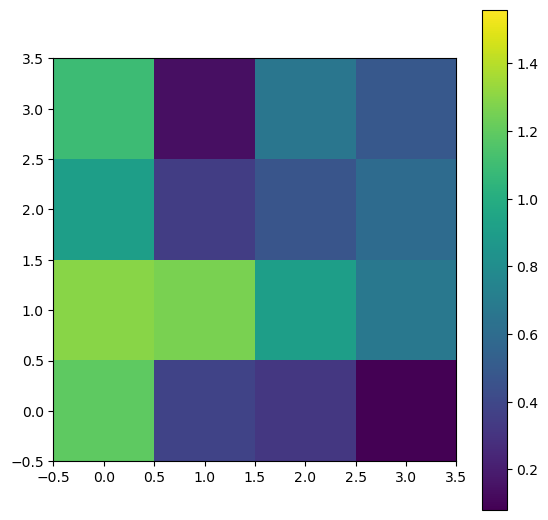

In [6]:
output_plot(A_norm, mem_rate)

In [6]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, layers):
        super(SimpleNeuralNetwork, self).__init__()
        
        self._depth = len(layers) - 1
        self._activation_function = torch.nn.Tanh
        layers_list = list()
        
        for i in range(self._depth - 1): 
            layers_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1], dtype=torch.complex64)))
            layers_list.append(('activation_%d' % i, self._activation_function()))
            
        layers_list.append(('layer_%d' % (self._depth - 1), torch.nn.Linear(layers[-2], layers[-1], dtype=torch.complex64)))
        layerDict = OrderedDict(layers_list)
        self._layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self._layers(x)
        return out

In [7]:
dnn = SimpleNeuralNetwork([3, 20, 20, 20, 20, 20, 20, 1])
dnn

SimpleNeuralNetwork(
  (_layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=20, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=20, out_features=20, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=20, out_features=1, bias=True)
  )
)

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [8]:
class ComplexOptimizer(torch.optim.Optimizer):
    def __init__(self, optimizer_type, params, **kwargs):
        self.defaults = kwargs
        super(ComplexOptimizer, self).__init__(params, self.defaults)

        # Split complex parameters into real and imaginary parts
        real_params = []
        imag_params = []
        self.is_imag = []
        for param_group in self.param_groups:
            for param in param_group["params"]:
                if param.is_complex():
                    real_param = param.real.clone().detach().requires_grad_(True)
                    imag_param = param.imag.clone().detach().requires_grad_(True)
                    real_params.append(real_param)
                    imag_params.append(imag_param)
                    self.is_imag.append(True)
                else:
                    real_params.append(param)
                    self.is_imag.append(False)

        # Create two optimizers, one for real parts and one for imaginary parts
        self.real_optimizer = optimizer_type(real_params, **self.defaults)
        self.imag_optimizer = optimizer_type(imag_params, **self.defaults)
        
    @torch.no_grad()
    def step(self, closure):
        # Define a closure for real parts
        def real_closure():
            real_loss = closure()
            if real_loss is not None:
                real_loss.backward(retain_graph=True)
            return real_loss

        # Define a closure for imaginary parts
        def imag_closure():
            imag_loss = closure()
            if imag_loss is not None:
                imag_loss.backward()
            return imag_loss

        # Optimize real and imaginary parts separately
        with torch.enable_grad():
            real_loss = self.real_optimizer.step(real_closure)
            imag_loss = self.imag_optimizer.step(imag_closure)

        # Update the original complex parameters with the optimized real and imaginary parts
        for param_group, real_param_group, imag_param_group in zip(self.param_groups, self.real_optimizer.param_groups, self.imag_optimizer.param_groups):
            for param, real_param, imag_param in zip(compress(param_group["params"], self.is_imag), compress(real_param_group["params"],self.is_imag), imag_param_group["params"]):
                if param.is_complex():
                    with torch.no_grad():
                        param.copy_(torch.complex(real_param, imag_param))

        return real_loss + imag_loss

In [9]:
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [10]:
class PINN:
    def __init__(self, X, u, layers, lb, ub, lambda_reg=None, optimizer=Lion, myu_bound=1, clipping=False):
        # boundary conditions
        self.lb = torch.tensor(lb, dtype=torch.int64).to(device)
        self.ub = torch.tensor(ub, dtype=torch.int64).to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        self.t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)          
        self.u = torch.tensor(u, requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
           
        # self.myu = torch.randn(2, 4, dtype=torch.float64, requires_grad=True)
        # # self.myu.data = transform_and_stack(self.myu.data, 10, 25).flatten().
        # # self.myu = torch.nn.Parameter(self.myu.to(device))
        # self.myu = transform_and_stack(self.myu.to(device), 4, 25)

        # # simple neural network  
        # self.dnn = SimpleNeuralNetwork(layers).to(device)
        # self.dnn.register_parameter('myu', torch.randn(2, 4, dtype=torch.float64, requires_grad=True))
        # self.dnn.myu.data = nn.Parameter(torch.randn(2, 4).to(device))
        
        # Create a tensor with random values
        self.myu = torch.randn(4, 2, dtype=torch.float64, requires_grad=True).to(device)
        self.myu = nn.Parameter(self.myu)
        self.dnn = SimpleNeuralNetwork(layers).to(device)
        self.dnn.register_parameter('myu', self.myu)

        # self.dnn.myu = nn.Parameter(transformed_myu_tensor).to(device)
        
        params_list = self.dnn.parameters()
        
        self.optimizer = ComplexOptimizer(
            optimizer_type=optimizer,   # Lion, LBFGS
            params=params_list,
            lr=1.4,                                      # Learning Rate
            max_iter=1200,                                # Default max # of iterations per optimization step                                                                    #
            tolerance_grad=1e-2,                        # Default termination tolerance on first order optimality
            tolerance_change=1e-2,                      # Default termination tolerance on function value/parameter changes
            history_size=1200
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=1.2)        
        self.optimizer_counter = 0
        
        self.history = {
            'u_loss': [],
            'f_loss': [],
            'total_loss': [],
            'myu': []
        }
        
        self.lambda_reg = lambda_reg
        self.myu_bound = myu_bound

        self.initial_f_loss = None
        self.initial_u_loss = None
        
        self.clipping = clipping
        
        # print("u", self.u.shape)
        # print("x", self.x.shape)
        # print("y", self.y.shape)
        # print("t", self.t.shape)
        
    def net_u(self, x, y, t):
        u = self.dnn(torch.cat([x, y, t], dim=1).view(-1, 3))
        return u
   
    def clip(self, x, lower_bound, upper_bound):
        return torch.clamp(x, min=lower_bound, max=upper_bound)
    
    def update_myu(self):
        with torch.no_grad():
            self.myu.data = self.clip(self.myu, 0.0, self.myu_bound)
    
    def net_f(self, x, y, t):
        torch.autograd.set_detect_anomaly(True)
        u = self.net_u(x, y, t).view(200, 4, 4)
     
        myu = self.myu
        # myu = transform_and_stack(myu, 4, 200).to(device)
        myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
        myu = myu.view(200, 4, 4)

        # print(myu.shape)
        # myu.requires_grad=True

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            create_graph=True
        )[0]
        u_yy = torch.autograd.grad(
            u_y, y,
            grad_outputs=torch.ones_like(u_y),
            create_graph=True
        )[0]
        
        # print("u", u.shape)
        # print("u_t", u_t.shape)
        # print("u_x", u_x.shape)
        # print("u_y", u_y.shape)
        # print("u_xx", u_xx.shape)
        # print("u_yy", u_yy.shape)
        # print("torch.pow(torch.abs(u), 2)*u", (torch.pow(torch.abs(u), 2)*u).shape)
       
        f = u_t - myu*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u
        
        # free_memory(u_t, u_x, u_y, u_xx, u_yy)
        return f
    
    def loss_bc(self, x, y, t):
        
        torch.autograd.set_detect_anomaly(True)
        u = self.net_u(x, y, t).view(200, 4, 4)
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # Under maintenance!
        # boundary_error_x_lb = ((u_x_lb - u_x_lb_correct)**2).mean()
        # boundary_error_x_ub = ((u_x_ub - u_x_ub_correct)**2).mean()
        
        # boundary_error_y_lb = ((u_y_lb - u_y_lb_correct)**2).mean()
        # boundary_error_y_ub = ((u_y_ub - u_y_ub_correct)**2).mean()
        
        # boundary_error = boundary_error_x_lb + boundary_error_x_ub + \
        #                  boundary_error_y_lb + boundary_error_y_ub
        
        # Add boundary error term to your f function
        
        u_x_lb = u_x[self.lb]
        u_x_ub = u_x[self.ub]

        u_y_lb = u_y[self.lb]
        u_y_ub = u_y[self.ub]
        
        # print(u_x_lb.shape)
        
        # u_x_lb_correct = torch.zeros_like(self.lb)
        # u_x_ub_correct = torch.zeros_like(self.ub)
        # u_y_lb_correct = torch.zeros_like(self.lb)
        # u_y_ub_correct = torch.zeros_like(self.ub)

        u_x_lb_correct = self.lb[0] # if the first coordinate of lb is x
        u_x_ub_correct = self.ub[0] # if the first coordinate of ub is x
        u_y_lb_correct = self.lb[1] # if the second coordinate of lb is y
        u_y_ub_correct = self.ub[1] # if the second coordinate of ub is y

        # print(u_x_lb_correct.shape)

        boundary_error_x_lb = ((u_x_lb - u_x_lb_correct)**2).mean()
        boundary_error_x_ub = ((u_x_ub - u_x_ub_correct)**2).mean()
        
        boundary_error_y_lb = ((u_y_lb - u_y_lb_correct)**2).mean()
        boundary_error_y_ub = ((u_y_ub - u_y_ub_correct)**2).mean()
        
        boundary_error = boundary_error_x_lb + boundary_error_x_ub + \
                        boundary_error_y_lb + boundary_error_y_ub
                        
        return boundary_error
    
    def loss_func(self):        
        
        u_pred = self.net_u(self.x, self.y, self.t).view(200, 4, 4)
        f_pred = self.net_f(self.x, self.y, self.t)
        loss_bc = self.loss_bc(self.x, self.y, self.t)
        
        u_loss = torch.mean(torch.abs((self.u - u_pred) ** 2))
        f_loss = torch.mean(torch.abs(f_pred) ** 2)
        bc_loss = torch.mean(torch.abs(loss_bc) ** 2)
        
        if self.lambda_reg is not None:
            myu_reg = self.lambda_reg * torch.sum(self.myu)
            loss = u_loss + f_loss + myu_reg
        else:
            loss = u_loss + f_loss + bc_loss
        
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        
        if self.clipping:
            self.update_myu()
        
        self.optimizer_counter += 1
        # if self.optimizer_counter % 10 == 0:
        #     print('Iter: %d, u_loss: %s, f_loss: %s, total loss: %s, myu:\n %s \n' % 
        #             (
        #                 self.optimizer_counter,
        #                 u_loss.item(),
        #                 f_loss.item(),
        #                 loss.item(), 
        #                 self.myu.cpu().detach().numpy()
        #             )
        #         )
            
        free_memory(u_loss, f_loss, u_pred, f_pred)
        return loss

    def train(self, epochs):
        self.dnn.train()
        
        self.history = {
            'u_loss': [],
            'f_loss': [],
            'total_loss': [],
            'myu': []
        }
        
        for epoch in tqdm(range(epochs)):
            
            u_pred = self.net_u(self.x, self.y, self.t).view(200, 4, 4)
            f_pred = self.net_f(self.x, self.y, self.t)
            loss_bc = self.loss_bc(self.x, self.y, self.t)
            
            u_loss = torch.mean(torch.abs((self.u - u_pred) ** 2))
            f_loss = torch.mean(torch.abs(f_pred) ** 2)
            bc_loss = torch.mean(torch.abs(loss_bc) ** 2)
            
            # store the initial losses
            if epoch == 0:
                self.initial_f_loss = f_loss.item()
                self.initial_u_loss = u_loss.item()
                
            # check early stopping conditions
            if (self.initial_f_loss / f_loss.item() >= 1000 and 
                self.initial_u_loss - u_loss.item() >= 10):
                print('It: %d, u_loss: %s, f_loss: %s, total loss: %s unique myus: %s' % 
                       (
                        epoch,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(), 
                        self.dnn.myu.cpu().detach()
                    )
                )
                print("Early stopping condition reached.")
                break
            
            if self.lambda_reg is not None:
                myu_reg = self.lambda_reg * torch.sum(self.myu)
                loss = u_loss + f_loss + myu_reg
            else:
                loss = u_loss + f_loss + bc_loss

            self.history['u_loss'].append(u_loss.item())
            self.history['f_loss'].append(f_loss.item())
            self.history['total_loss'].append(loss.item())
            self.history['myu'].append(self.dnn.myu.cpu().detach().numpy())
            
            self.optimizer_Adam.zero_grad()
            loss.backward(retain_graph=True)
            self.optimizer_Adam.step()
            
            if self.clipping:
                self.update_myu()
            
            if epoch % 10 == 0:
                print('It: %d, u_loss: %s, f_loss: %s, total loss: %s unique myus: %s' % 
                       (
                        epoch,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(), 
                        np.unique(self.dnn.myu.cpu().detach().numpy())
                    )
                )
            
            free_memory(u_loss, f_loss, u_pred)
            if epoch % 30 == 0:
                self.optimizer.step(self.loss_func)
                        
    def predict(self, X):
        
        x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex64).reshape(200, 4, 4).to(device)  
        
        self.dnn.eval()
        
        u = self.net_u(x, y, t)
        f = self.net_f(x, y, t)
        
        u = u.view(parameters.mem_rat, parameters.Nx, parameters.Ny)
        
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        
        return u, f

In [19]:
snn_layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

x = np.linspace(0, Lx, Nx).flatten()[:, None]
y = np.linspace(0, Ly, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact

# boundary conditions
lb = X_star.min(0) # lower bound
ub = X_star.max(0) # upper bound

In [20]:
# from GPUtil import showUtilization as gpu_usage

model = PINN(
    X=X_star, 
    u=u_star.reshape(-1, 1),
    layers=snn_layers, 
    lb=lb, 
    ub=ub,
    lambda_reg=None,
    optimizer=torch.optim.LBFGS,
    myu_bound=None, #np.max(parameters.myu_in[:, :, :]),
    clipping=False
)

# gpu_usage()

In [22]:
number_of_iteration = 3500
model.train(number_of_iteration)

  0%|          | 0/3500 [00:00<?, ?it/s]

It: 0, u_loss: 62.916561126708984, f_loss: 72806361154.21222, total loss: 72809939512.12878 unique myus: [-2.18773146 -1.63068646 -1.56481671 -1.54941492 -1.32679304 -0.91235892
 -0.24492827  0.24619221]


  0%|          | 11/3500 [00:23<35:33,  1.64it/s]  

It: 10, u_loss: 380.27392578125, f_loss: 6.652619444563587e+27, total loss: 6.652625439548245e+27 unique myus: [-4.19684460e+04 -1.03091118e+04 -5.78845165e+03  2.01840528e+03
  1.12527357e+04  3.28476963e+04  3.10908303e+05  8.27390397e+06]


  1%|          | 21/3500 [00:27<24:21,  2.38it/s]

It: 20, u_loss: 834.6639404296875, f_loss: 6.652660965226033e+27, total loss: 6.652666895130299e+27 unique myus: [-4.19692910e+04 -1.03059356e+04 -5.79311871e+03  2.01091735e+03
  1.12616955e+04  3.28607650e+04  3.10920066e+05  8.27389907e+06]


  1%|          | 30/3500 [00:31<28:29,  2.03it/s]

It: 30, u_loss: 1927.641845703125, f_loss: 6.652660696518822e+27, total loss: 6.652666551803509e+27 unique myus: [-4.19582879e+04 -1.02926230e+04 -5.78305849e+03  2.01723597e+03
  1.12761919e+04  3.28755077e+04  3.10934802e+05  8.27390909e+06]


  1%|          | 41/3500 [01:05<37:36,  1.53it/s]  

It: 40, u_loss: 63.41550064086914, f_loss: 1.452020772371951e+23, total loss: 1.4520210846001176e+23 unique myus: [1.99458832e+08 3.17315740e+08 3.71375959e+08 6.02058752e+08
 8.87182907e+08 1.45078355e+09 2.03855448e+09 1.08924915e+11]


  1%|▏         | 51/3500 [01:09<25:57,  2.21it/s]

It: 50, u_loss: 63.4163703918457, f_loss: 1.4520208184995753e+23, total loss: 1.452021130727742e+23 unique myus: [1.99458836e+08 3.17315744e+08 3.71375963e+08 6.02058755e+08
 8.87182910e+08 1.45078355e+09 2.03855448e+09 1.08924915e+11]


  2%|▏         | 60/3500 [01:15<27:51,  2.06it/s]

It: 60, u_loss: 63.41648483276367, f_loss: 1.4520208217120325e+23, total loss: 1.4520211339401991e+23 unique myus: [1.99458838e+08 3.17315745e+08 3.71375964e+08 6.02058756e+08
 8.87182911e+08 1.45078356e+09 2.03855449e+09 1.08924915e+11]


  2%|▏         | 60/3500 [01:32<1:28:29,  1.54s/it]


KeyboardInterrupt: 

In [ ]:
print(np.min(model.history['u_loss']))
print(np.min(model.history['f_loss']))
print(np.max(model.history['myu']))

In [ ]:
# skip_size = 1000
# fig, axs = plt.subplots(2, 3, figsize=(15, 8))
# fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

# axs[0,0].plot(iterations, model.history['f_loss'], label="f loss")
# axs[0,0].set_xlabel('Number of iterations')
# axs[0,0].set_ylabel('Loss')
# axs[0,0].set_title("f loss")

# axs[0,1].plot(iterations, model.history['u_loss'], label="u loss")
# axs[0,1].set_xlabel('Number of iterations')
# axs[0,1].set_ylabel('Loss')
# axs[0,1].set_title("u loss")

# # axs[0,2].plot(iterations, model.history['total_loss'], label="total loss")
# # axs[0,2].set_xlabel('Number of iterations')
# # axs[0,2].set_ylabel('total loss')
# # axs[0,2].set_title("total loss")

# axs[0,2].plot(iterations, model.history['myu'], label="myu")
# axs[0,2].axhline(y=np.unique(parameters.myu_in), color='r', linestyle='--', label=f'myu target')
# axs[0,2].set_xlabel('Number of iterations')
# axs[0,2].set_ylabel('myu')
# axs[0,2].set_title("myu")

# axs[1,0].plot(iterations[skip_size:], model.history['f_loss'][skip_size:], label="f loss")
# axs[1,0].set_xlabel('Number of iterations')
# axs[1,0].set_ylabel('Loss')
# axs[1,0].set_title("f loss_")

# axs[1,1].plot(iterations[skip_size:], model.history['u_loss'][skip_size:], label="u loss")
# axs[1,1].set_xlabel('Number of iterations')
# axs[1,1].set_ylabel('Loss')
# axs[1,1].set_title("u loss_")

# # axs[1,2].plot(iterations[skip_size:], model.history['total_loss'][skip_size:], label="total loss")
# # axs[1,2].set_xlabel('Number of iterations')
# # axs[1,2].set_ylabel('total loss')
# # axs[1,2].set_title("total loss_")

# axs[1,2].plot(iterations[skip_size:], model.history['myu'][skip_size:], label="myu pred")
# axs[1,2].axhline(y=np.unique(parameters.myu_in), color='r', linestyle='--', label=f'myu target')
# axs[1,2].set_xlabel('Number of iterations')
# axs[1,2].set_ylabel('myu')
# axs[1,2].set_title("myu_")

# fig.suptitle("Model performance")
# plt.tight_layout()
# plt.show()

iterations = np.linspace(0, len(model.history['f_loss']), len(model.history['f_loss']))
skip_size = 1000
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # Only one row now
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

axs[0].plot(iterations, model.history['f_loss'], label="f loss")
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Log-scaled Loss')
axs[0].set_title("f loss")
axs[0].set_yscale('log')

axs[1].plot(iterations, model.history['u_loss'], label="u loss")
axs[1].set_xlabel('Number of iterations')
axs[1].set_ylabel('Log-scaled Loss')
axs[1].set_title("u loss")
axs[1].set_yscale('log')

# axs[2].plot(iterations, model.history['myu'], label="myu")
# axs[2].axhline(y=np.unique(parameters.myu_in), color='r', linestyle='--', label=f'myu target')
# axs[2].set_xlabel('Number of iterations')
# axs[2].set_ylabel('Log-scaled myu')
# axs[2].set_title("myu")
# axs[2].set_yscale('log')

fig.suptitle("Model performance")
plt.tight_layout()
plt.show()

In [ ]:
# myu_history = [np.array(myu).flatten() for myu in model.history['myu']] # Flatten each myu to a 1D array
# myu_components = list(zip(*myu_history))
# myu_in_values_flattened = np.array(np.unique(parameters.myu_in)).flatten()

# color_cycle = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# myu_tensor_shape = model.dnn.myu.shape
# num_rows, num_cols, _ = myu_tensor_shape

# fig, axs = plt.subplots(len(np.unique(myu_history)), len(np.unique(myu_history)), figsize=(15, 8))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)

# for i in tqdm(range(len(np.unique(myu_history)))):
#     for j in tqdm(range(len(np.unique(myu_history)))):
#         # Calculate the flat index for the myu component and target value
#         flat_idx = i * num_cols + j

#         axs[i, j].plot(iterations, myu_components[flat_idx])
#         color = next(color_cycle)
#         axs[i, j].axhline(y=myu_in_values_flattened[flat_idx], color=color, linestyle='--', label=f'myu target {i+1}, {j+1}')
#         axs[i, j].set_title(f'Myu {i+1}, {j+1}')
#         axs[i, j].set_xlabel('Number of iterations')
#         axs[i, j].set_ylabel('myu')
#         axs[i, j].legend()

# fig.suptitle("Model performance")
# plt.show()


In [ ]:
# # Calculate max of loss histories
# max_u_loss = np.max(model.history['u_loss'])
# max_f_loss = np.max(model.history['f_loss'])
# max_total_loss = np.max(model.history['total_loss'])

# # Normalize loss histories
# f_loss_norm = (model.history['f_loss'] - np.min(model.history['f_loss'])) / (max_f_loss - np.min(model.history['f_loss']))
# u_loss_norm = (model.history['u_loss'] - np.min(model.history['u_loss'])) / (max_u_loss - np.min(model.history['u_loss']))
# total_loss_norm = (model.history['total_loss'] - np.min(model.history['total_loss'])) / (max_total_loss - np.min(model.history['total_loss']))

# skip_size = 3000
# fig, axs = plt.subplots(2, 3, figsize=(15, 8))
# fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

# # Plotting normalized total loss, u_loss and f_loss with skip size
# axs[0,0].plot(iterations[skip_size:], total_loss_norm[skip_size:], label="total loss norm")
# axs[0,1].plot(iterations[skip_size:], u_loss_norm[skip_size:], label="u loss norm")
# axs[0,2].plot(iterations[skip_size:], f_loss_norm[skip_size:], label="f loss norm")

# # Plotting normalized total loss, u_loss and f_loss for all iterations
# axs[1,0].plot(iterations, total_loss_norm, label="total loss norm")
# axs[1,1].plot(iterations, u_loss_norm, label="u loss norm")
# axs[1,2].plot(iterations, f_loss_norm, label="f loss norm")

# # Labeling axes and setting titles
# for i in range(2):
#     for j in range(3):
#         axs[i,j].set_xlabel('Number of iterations')
#         axs[i,j].set_ylabel('Normalized Loss')
#         axs[i,j].legend()

# axs[0,0].set_title("total loss norm (skipped)")
# axs[0,1].set_title("u loss norm (skipped)")
# axs[0,2].set_title("f loss norm (skipped)")
# axs[1,0].set_title("total loss norm")
# axs[1,1].set_title("u loss norm")
# axs[1,2].set_title("f loss norm")

# fig.suptitle("Model performance (normalized values)")
# plt.show()

In [ ]:
# # evaluations
# u_pred, f_pred = model.predict(X_star)
# u_pred = torch.tensor(u_pred)
# u_test = torch.tensor(u_star)
# # error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)

# myu_model = np.array(model.dnn.myu.detach().cpu()).flatten()
# myu_target = np.array(np.unique(parameters.myu_in)).flatten()

# # # Ensure that myu_model and myu_target are of the same size
# # assert len(myu_model) == len(myu_target), "Sizes of myu_model and myu_target don't match"

# myu_error = (myu_model / myu_target) * 100

# print("Myu model: ", myu_model.tolist())
# print("Myu target: ", myu_target.tolist())
# print('Myu percentage of the target: ', myu_error.tolist())

# # myu_target = np.unique(parameters.myu_in)
# # myu_error = (model.myu.detach().cpu().numpy() * 100) / myu_target
# # print('Myu percentage of the target: ', myu_error) 
# # print('Error u: ', error_u)

In [ ]:
print(np.count_nonzero(np.unique(model.dnn.myu.detach().cpu().numpy())))
print(np.count_nonzero(np.unique(parameters.myu_in)))

In [ ]:
u_pred, f_pred = model.predict(X_star)
print(u_pred.shape, f_pred.shape)

In [ ]:
path="combo_test"
create_gifs(
    memory_rate=parameters.mem_rat, 
    u_pred=u_pred, 
    original=parameters.A_original, 
    save=True, 
    path_for_gif=path+".gif", 
    duration=500, 
    title=" "
)
Image(filename=path+".gif")

In [ ]:
gif = imageio.mimread(path+".gif", memtest=False)
nums = len(gif)
print("Total {} frames in the gif {}!".format(nums, path+".gif"))

In [ ]:
# Convert form BGR to RGB
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in gif]

# Save frames to video
out = cv2.VideoWriter(path+'.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (imgs[0].shape[1], imgs[0].shape[0]))

for img in imgs:
    out.write(img)

out.release()